# random forest

In [87]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer

from sklearn import tree
import pydotplus
from IPython.display import Image
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

## data preprocess

### read train.csv, preprocess

In [88]:
# load data & show head
df = pd.read_csv('../cs5228/train.csv')
print(df.shape)
df.head()

(24421, 14)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,exceeds50K
0,30,?,147215,Some-college,10,Never-married,?,Own-child,Female,0,0,30,United-States,0
1,60,Private,173960,Bachelors,13,Divorced,Prof-specialty,Not-in-family,Female,0,0,42,United-States,0
2,52,?,105428,Some-college,10,Married-civ-spouse,?,Husband,Male,0,0,12,United-States,0
3,37,Private,112497,Bachelors,13,Married-civ-spouse,Sales,Husband,Male,0,0,60,United-States,0
4,63,Private,137843,Some-college,10,Married-civ-spouse,Sales,Husband,Male,7298,0,48,United-States,1


In [89]:
# split features and labels
X = df.drop(['exceeds50K'],axis=1)
Y = df['exceeds50K']
X.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country
0,30,?,147215,Some-college,10,Never-married,?,Own-child,Female,0,0,30,United-States
1,60,Private,173960,Bachelors,13,Divorced,Prof-specialty,Not-in-family,Female,0,0,42,United-States
2,52,?,105428,Some-college,10,Married-civ-spouse,?,Husband,Male,0,0,12,United-States


### read test.csv, preprocess

In [90]:
df_test = pd.read_csv('../cs5228/test.csv')
print(df_test.shape)
X_test = df_test
df_test.head(3)

(24421, 13)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country
0,23,Private,32732,Some-college,10,Married-civ-spouse,Sales,Husband,Male,0,0,25,United-States
1,69,Private,165017,HS-grad,9,Widowed,Machine-op-inspct,Unmarried,Male,2538,0,40,United-States
2,27,Private,36440,Bachelors,13,Never-married,Sales,Not-in-family,Female,0,0,40,United-States


In [91]:
# replace missing value ' ?' by mode

feature_list = X.columns

# count missing value ' ?' 
print('missing value count in train.scv')
for feature in feature_list:
    print(feature, ' ', len(X[X[feature] == ' ?']))

print('\nmissing value count in test.csv')
for feature in feature_list:
    print(feature, ' ', len(X_test[X_test[feature]==' ?']))

# replace
X_all = pd.concat([X,X_test], axis = 0)
imputer = SimpleImputer(missing_values=' ?', strategy='most_frequent')
imputer.fit(X_all)
X = pd.DataFrame(imputer.transform(X), columns = feature_list)
X_test = pd.DataFrame(imputer.transform(X_test), columns = feature_list)
X.head(3)

missing value count in train.scv
age   0
workclass   1392
fnlwgt   0
education   0
education-num   0
marital-status   0
occupation   1399
relationship   0
sex   0
capital-gain   0
capital-loss   0
hours-per-week   0
native-country   410

missing value count in test.csv
age   0
workclass   1407
fnlwgt   0
education   0
education-num   0
marital-status   0
occupation   1410
relationship   0
sex   0
capital-gain   0
capital-loss   0
hours-per-week   0
native-country   447


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country
0,30,Private,147215,Some-college,10,Never-married,Prof-specialty,Own-child,Female,0,0,30,United-States
1,60,Private,173960,Bachelors,13,Divorced,Prof-specialty,Not-in-family,Female,0,0,42,United-States
2,52,Private,105428,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,Male,0,0,12,United-States


In [92]:
# marital-status into single, married
print(set(X['marital-status'].values))
single_list = [' Separated', ' Divorced', ' Widowed', ' Never-married']
married_list = [' Married-AF-spouse', ' Married-spouse-absent', ' Married-civ-spouse']

X['marital-status'][X['marital-status'].isin(married_list)] = 'married'
X['marital-status'][X['marital-status'].isin(single_list)] = 'single'
X_test['marital-status'][X_test['marital-status'].isin(married_list)] = 'married'
X_test['marital-status'][X_test['marital-status'].isin(single_list)] = 'single'
X.head()

{' Separated', ' Married-AF-spouse', ' Married-spouse-absent', ' Divorced', ' Married-civ-spouse', ' Widowed', ' Never-married'}


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country
0,30,Private,147215,Some-college,10,single,Prof-specialty,Own-child,Female,0,0,30,United-States
1,60,Private,173960,Bachelors,13,single,Prof-specialty,Not-in-family,Female,0,0,42,United-States
2,52,Private,105428,Some-college,10,married,Prof-specialty,Husband,Male,0,0,12,United-States
3,37,Private,112497,Bachelors,13,married,Sales,Husband,Male,0,0,60,United-States
4,63,Private,137843,Some-college,10,married,Sales,Husband,Male,7298,0,48,United-States


### embedding, train&test data together

In [93]:
# transfer string feature into int

# features in string to be encoded
encoding_features = ['workclass','education','marital-status','occupation','relationship','sex','native-country']

# to include all possible values
X_all = pd.concat([X,X_test], axis = 0)
for feature in encoding_features:
    encoder = preprocessing.LabelEncoder()
    encoder.fit(X_all[feature])
    X[feature] = encoder.transform(X[feature])
    X_test[feature] = encoder.transform(X_test[feature])

X.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country
0,30,3,147215,15,10,1,9,3,0,0,0,30,38
1,60,3,173960,9,13,1,9,1,0,0,0,42,38
2,52,3,105428,15,10,0,9,0,1,0,0,12,38


In [94]:
# feature scaling

scaler = preprocessing.StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns = feature_list)
X_test = pd.DataFrame(scaler.transform(X_test), columns = feature_list)
X.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country
0,-0.627855,-0.086978,-0.397416,1.218346,-0.037490,0.946594,0.714447,0.965669,-1.421717,-0.145954,-0.216863,-0.849954,0.263597
1,1.565644,-0.086978,-0.141947,-0.335686,1.127814,0.946594,0.714447,-0.279387,-1.421717,-0.145954,-0.216863,0.120349,0.263597
2,0.980711,-0.086978,-0.796568,1.218346,-0.037490,-1.056419,0.714447,-0.901915,0.703375,-0.145954,-0.216863,-2.305408,0.263597


In [95]:
X_train ,X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state = 0)

## random forest training

In [96]:
clf = RandomForestClassifier(n_estimators=50)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_val)
accuracy_score(Y_val,Y_pred)

0.8569673809198853

### adjusting and improving hyperparameters

#### try n_estimator

0.8563124412694615 141


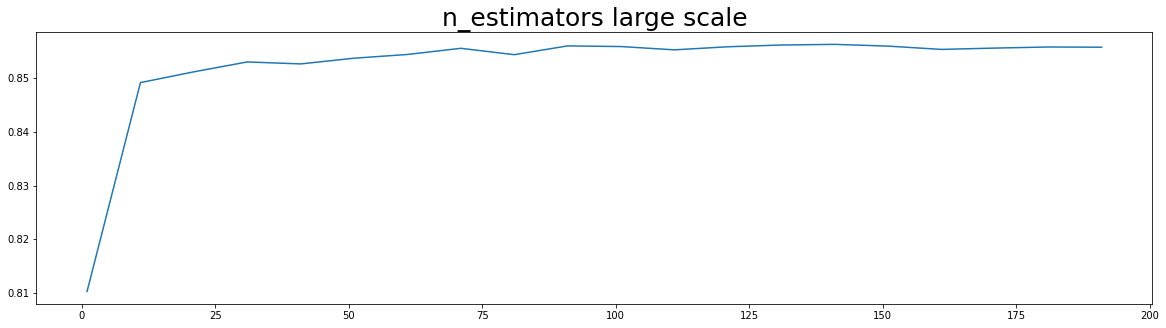

In [97]:
# n_estimator, large scale
score_list = []
for i in range(1, 200, 10):
    clf = RandomForestClassifier(n_estimators = i, n_jobs=-1, random_state=90)
    score = cross_val_score(clf, X, Y, cv=10).mean()
    score_list.append(score)
print(max(score_list), score_list.index(max(score_list))*10+1)
plt.figure(figsize=[20,5])
plt.plot(range(1, 200, 10), score_list)
plt.title("n_estimators large scale", fontsize=25)
plt.show()

0.8564762749576502 120


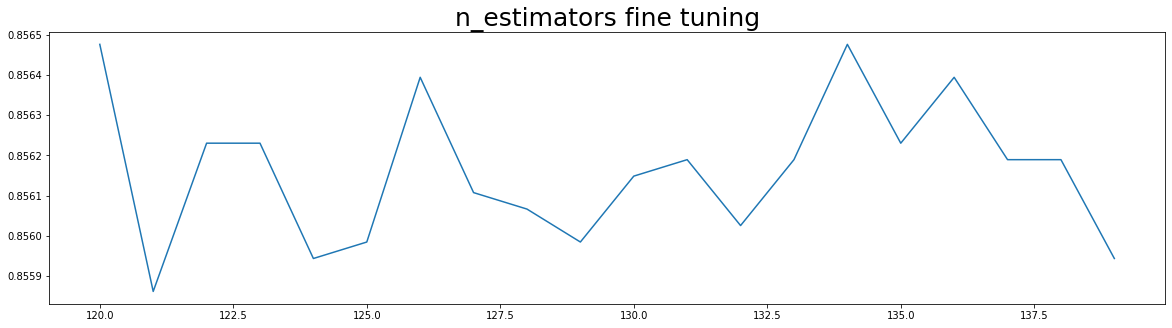

In [98]:
# n_estimator, fine tuning
score_list = []
for i in range(120, 140):
    clf = RandomForestClassifier(n_estimators = i, n_jobs=-1, random_state=90)
    score = cross_val_score(clf, X, Y, cv=10).mean()
    score_list.append(score)
print(max(score_list), score_list.index(max(score_list))+120)
plt.figure(figsize=[20,5])
plt.plot(range(120,140), score_list)
plt.title("n_estimators fine tuning", fontsize=25)
plt.show()

# find the best n_estimator is around 122

#### try max_depth

0.8640925635194977 14


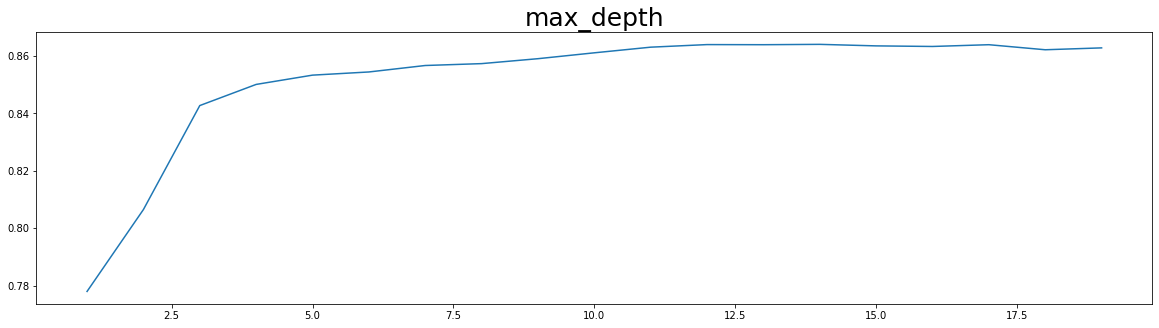

In [99]:
# max_depth
score_list = []
for i in range(1, 20):
    clf = RandomForestClassifier(n_estimators = 122, max_depth=i, n_jobs=-1, random_state=90)
    score = cross_val_score(clf, X, Y, cv=10).mean()
    score_list.append(score)
print(max(score_list), score_list.index(max(score_list))+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,20), score_list)
plt.title("max_depth", fontsize=25)
plt.show()

#### try min_samples_leaf

0.8639698307320083 2


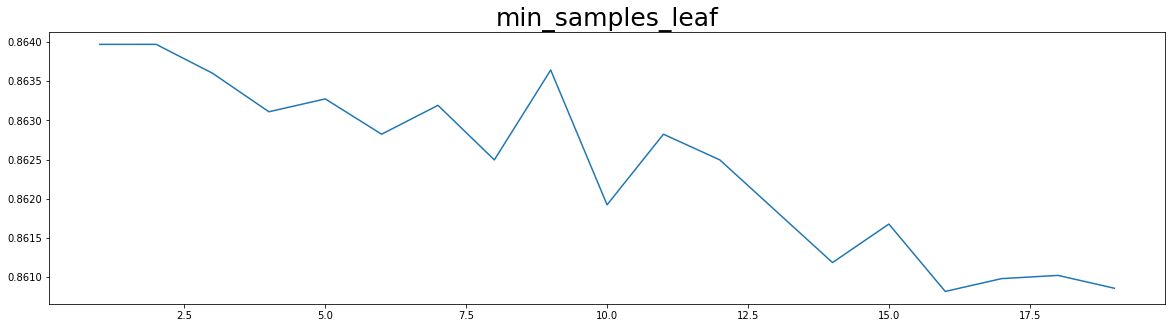

In [100]:
# min_samples_leaf
score_list = []
for i in range(1, 20):
    clf = RandomForestClassifier(n_estimators = 122, max_depth=13, min_samples_leaf = i, n_jobs=-1, random_state=90)
    score = cross_val_score(clf, X, Y, cv=10).mean()
    score_list.append(score)
print(max(score_list), score_list.index(max(score_list))+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,20), score_list)
plt.title("min_samples_leaf", fontsize=25)
plt.show()

#### try max_features

0.857090324425568 1


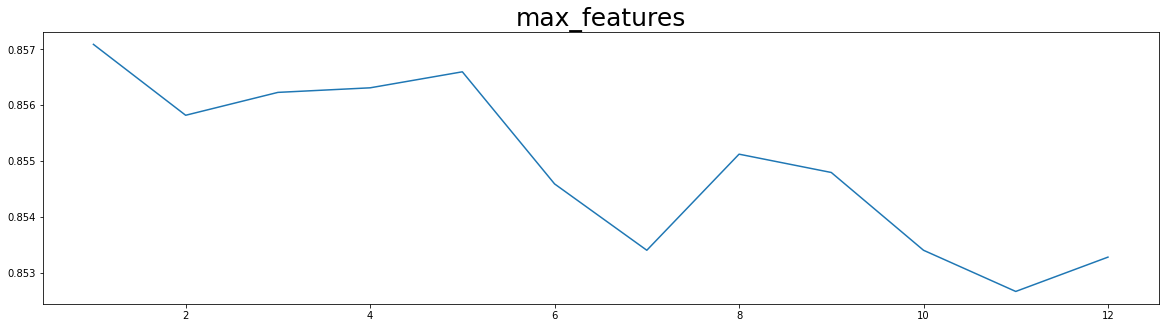

In [101]:
# max_features

score_list = []
for i in range(1, 13):
    clf = RandomForestClassifier(n_estimators = 122, max_features=i, n_jobs=-1, random_state=90)
    score = cross_val_score(clf, X, Y, cv=10).mean()
    score_list.append(score)
print(max(score_list), score_list.index(max(score_list))+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,13), score_list)
plt.title("max_features", fontsize=25)
plt.show()

####  try class_weight, not obvious

In [109]:
clf = RandomForestClassifier(n_estimators=122, n_jobs = -1, random_state = 90, class_weight= 'balanced')
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_val)
print('accuracy', accuracy_score(Y_val, Y_pred))
print(classification_report(Y_val, Y_pred))

accuracy 0.858059232973932
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      5573
           1       0.75      0.61      0.67      1754

    accuracy                           0.86      7327
   macro avg       0.82      0.77      0.79      7327
weighted avg       0.85      0.86      0.85      7327



#### compare entropy & gini

In [103]:
# entropy
clf1 = RandomForestClassifier(criterion='entropy',n_estimators=122, n_jobs = -1, max_depth=13, random_state = 90)
clf1.fit(X_train, Y_train)
Y_pred1 = clf1.predict(X_val)
print('entropy')
print('accuracy', accuracy_score(Y_val, Y_pred1))
print(classification_report(Y_val, Y_pred1))

# gini
clf2 = RandomForestClassifier(n_estimators=122, n_jobs = -1, max_depth=13, random_state = 90)
clf2.fit(X_train, Y_train)
Y_pred2 = clf2.predict(X_val)
print('------------------\ngini')
print('accuracy', accuracy_score(Y_val, Y_pred2))
print(classification_report(Y_val, Y_pred2))
# almost same, chose gini, faster

entropy
accuracy 0.8569673809198853
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      5573
           1       0.74      0.62      0.67      1754

    accuracy                           0.86      7327
   macro avg       0.81      0.78      0.79      7327
weighted avg       0.85      0.86      0.85      7327

------------------
gini
accuracy 0.8569673809198853
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      5573
           1       0.74      0.62      0.67      1754

    accuracy                           0.86      7327
   macro avg       0.81      0.78      0.79      7327
weighted avg       0.85      0.86      0.85      7327



### final model

In [104]:
clf = RandomForestClassifier(n_estimators=122, n_jobs = -1, max_depth=13, random_state = 90)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_val)
print('accuracy', accuracy_score(Y_val, Y_pred))
print(classification_report(Y_val, Y_pred))

accuracy 0.8628360857103863
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      5573
           1       0.78      0.59      0.67      1754

    accuracy                           0.86      7327
   macro avg       0.83      0.77      0.79      7327
weighted avg       0.86      0.86      0.86      7327



## predict test data

In [105]:
Y_test = clf.predict(X_test)
print(Y_test.shape)

(24421,)


### wirte predictions into file

In [106]:
# wirte into file
df_res = pd.read_csv('../cs5228/sample_submission.csv')
df_res['prediction'] = Y_test
print(df_res.head())
df_res.to_csv('../submissions/rf_submission.csv', index = False)

   id  prediction
0   1           0
1   2           0
2   3           0
3   4           0
4   5           0


### visualization to pdf

In [107]:
# trees = clf.estimators_
# # feature_list = X.columns
# for index, model in enumerate(trees[:2]):
#     filename = 'rf_tree' + str(index) + '.pdf'
#     dot_data = tree.export_graphviz(model,
#                                     feature_names=feature_list,
# #                                     out_file=None,
#                                     class_names=['not exceed50k', 'exceed50k'],
#                                     filled=True,
#                                     rounded=True,
#                                    special_characters=True)
#     graph = pydotplus.graph_from_dot_data(dot_data)
#     Image(graph.create_png())
#     graph.write_pdf(filename)